# Banned Books Analysis
Analysis of recently banned books in the US. 
* Data from https://docs.google.com/spreadsheets/d/1hTs_PB7KuTMBtNMESFEGuK-0abzhNxVv4tgpI5-iKe8/edit#gid=1171606318
* Article from PEN https://pen.org/report/banned-usa-growing-movement-to-censor-books-in-schools/

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas as pd
import time, tqdm, re, requests, json, os
import numpy as np
import seaborn as sns
from collections import Counter, defaultdict
import scipy
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# NLP stuff
from nltk import ngrams
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

# OPENAI
import openai
openai.api_key = os.environ["OPENAI_API_KEY"]

# Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['font.family'] = 'monospace'
COLORS = ['#FFBE0B', '#008080', '#3A86FF', '#8338EC',  '#FF006E', '#FB5607', ]
sns.set_palette(sns.color_palette(COLORS))
sns.color_palette(COLORS)


[(1.0, 0.7450980392156863, 0.043137254901960784),
 (0.0, 0.5019607843137255, 0.5019607843137255),
 (0.22745098039215686, 0.5254901960784314, 1.0),
 (0.5137254901960784, 0.2196078431372549, 0.9254901960784314),
 (1.0, 0.0, 0.43137254901960786),
 (0.984313725490196, 0.33725490196078434, 0.027450980392156862)]

## Helper Functions

In [1]:
def clean_tokens(tok_list):
    tok_list = [i.lower() for i in tok_list]
    for strip_char in ['"', "'", '“', '‘', '.', ',', '(', '-']:
        tok_list = [i.strip(strip_char) for i in tok_list]
    tok_list = [i for i in tok_list if i != '']
    tok_list = [i for i in tok_list if i not in stop_words]
    
    tok_list = [lemmatizer.lemmatize(i) for i in tok_list]
    
    return tok_list
    
def get_ngrams(token_list, n=2):
    return ngrams(token_list, n)

# https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)
    
def make_barchart(data, x, y, palette=COLORS):
    plt.figure(figsize=(10,5))
    ax = sns.barplot(data=data, 
                x=x, 
                y=y,
                palette=palette,
               )
    ax.bar_label(ax.containers[0], padding=3)
    ax.margins(x=0.1)
    wrap_labels(ax,30)

    plt.ylabel(None)
    sns.despine(top=True, right=True)
    
    return ax

NameError: name 'COLORS' is not defined

# Data Creation
Take the list of banned books from PEN and combine with metadata from Google Books

### Get metadata from Google Books for all unique books

In [8]:
# Google books API key
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

In [7]:
# Banned books in 2021-2022, compiled by PEN
df = pd.read_csv('pen_2022_banned_books.csv', header=2)
print("Number of unique books banned", len(df.Title.unique()))

vc = df.Title.value_counts()
print("Number of books banned in more than 1 place", len(vc[vc > 1]))
print("Number of books banned in more than 2 places", len(vc[vc > 2]))

Number of unique books banned 1648
Number of books banned in more than 1 place 345
Number of books banned in more than 2 places 136


In [9]:
# Clean up author and title names

unique_books = df[['Author', 'Title']]
# Remove duplicated
unique_books = unique_books[~unique_books.duplicated()]
# Split author name into first and last name
unique_books["Author_lastname"] = unique_books.Author.apply(lambda x: x.split(",")[0])
unique_books.reset_index(inplace=True, drop=True)
unique_books['Original_Title'] = unique_books['Title']
unique_books['Author_fullname'] = unique_books.Author.apply(lambda x: ' '.join(x.split(',')[::-1]).strip())

# Adding new metadata columns to dataframe
metadata_cols = ['description', 'printType', 'pageCount', 'categories', 'maturityRating', 
                'infoLink', 'averageRating', 'ratingsCount', 'ISBN_10', 'ISBN_13', 'Published_Google']
for m in metadata_cols: unique_books[m] = None

In [10]:
# Fix a few of the titles
for idx in unique_books[unique_books.Title.str.contains('Series\)')].index:
    # If the title is Blah blah (Blah Series), remove the (Blah Series) part
    unique_books.loc[idx, "Title"] = unique_books.loc[idx, 'Title'].split('(')[0].strip()

# Fix a few unique last names
idx=662
unique_books.loc[idx, "Author_lastname"] = "Johnson"
idx=1575
unique_books.loc[idx, "Author_lastname"] = "Popovic"

In [230]:
for i, row in tqdm.tqdm(unique_books.iterrows(), total=unique_books.shape[0]):
#     print(row.Title, "-", row.Author_lastname)
    
    title = row.Title.split(':')[0]
    res = requests.get(f'https://www.googleapis.com/books/v1/volumes?q={title}+inauthor:{row.Author_lastname}&key={GOOGLE_API_KEY}')
    
    # If being throttled, sleep and try again until no longer getting 429
    while 'error' in res.json() and res.json()['error']['code'] == 429:
        print('--sleeping--')
        time.sleep(5)
        res = requests.get(f'https://www.googleapis.com/books/v1/volumes?q={title}+inauthor:{row.Author_lastname}&key={GOOGLE_API_KEY}')

    # If non-throttling error OR can't find book
    if ('error' in res.json() and res.json()['error']['code'] != 429) or 'items' not in res.json():
        print(f"---Error for {row.Author_lastname}, {row.Title}")
        continue
    
    volumeInfo = res.json()['items'][0]['volumeInfo']
    
    for key in ['description', 'printType', 'pageCount', 'categories', 'maturityRating', 
                'infoLink', 'averageRating', 'ratingsCount']:
        if key in volumeInfo:
            unique_books.loc[i, key] = volumeInfo[key]
            
    if 'publishedDate' in volumeInfo:
        unique_books.loc[i, "Published_Google"] = volumeInfo['publishedDate']
    
    if 'industryIdentifiers' in volumeInfo:
        for t in volumeInfo['industryIdentifiers']:
            if t['type'] == 'ISBN_13':
                unique_books.loc[i, "ISBN_13"] = t['identifier']
            if t['type'] == 'ISBN_10':
                unique_books.loc[i, "ISBN_10"] = t['identifier']

    if i%5==0:
        time.sleep(3)
    

100%|██████████| 1656/1656 [01:46<00:00, 15.59it/s] 


In [ ]:
unique_books.to_csv('pen_unique_books_2022.csv', index=False)

### Combine Google Books metadata with PEN dataset

In [12]:
def get_year(x):
    for pattern in ['(\d\d\d\d)-\d\d-\d\d', '(\d\d\d\d)-\d\d']:
        if re.match(pattern, x):
            return re.match(pattern, x).group(1)
    return x

In [ ]:
df = pd.read_csv('pen_2022_banned_books.csv', header=2)

In [13]:
book_metadata = pd.read_csv('pen_unique_books_2022.csv')
book_metadata['Author_fullname'] = book_metadata.Author.apply(lambda x: ' '.join(x.split(',')[::-1]).strip())
book_metadata.Published_Google = book_metadata.Published_Google.apply(str)
book_metadata['Published_Year'] = book_metadata.Published_Google.apply(get_year)
for repeat_author in ['Rhodes, Jewel Parker','Perez, Ashley Hope']:
    book_metadata = book_metadata[book_metadata.Author!=repeat_author]
book_metadata = book_metadata[~book_metadata[['Author', 'Title']].duplicated()]

In [15]:
book_cols = ['Original_Title', 'Author_fullname', 'description', 'printType', 'pageCount', 'categories', 'maturityRating',
            'averageRating', 'ratingsCount', 'Published_Year']
df_merge = df\
    .merge(book_metadata[book_cols], left_on='Title', right_on='Original_Title', how='left')


# Data Analysis

## Banned Books (Overall)
Overall analyses on the types of books that are banned

Note: A book may be banned in one district of a state, but doesn't mean it's a state-wide ban.

In [16]:
book_metadata.printType.value_counts()

BOOK    1645
Name: printType, dtype: int64

### Page count distribution (histogram)

Page count -- most books are around 200-300 pages long. Bimodal though - huge spike in the sub-50 page long books. These are majority books tagged for juvenile fiction.

Text(0.5, 0, 'Number of Pages')

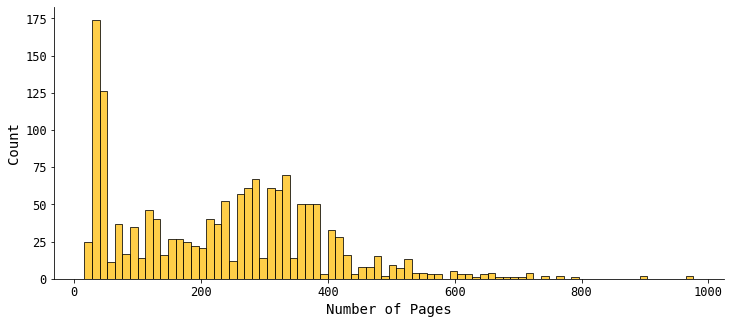

In [328]:
plt.figure(figsize=(12,5))
pc = book_metadata[book_metadata.pageCount > 0]
sns.histplot(data=pc, x='pageCount', bins=80)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
sns.despine(top=True, right=True)
plt.xticks(size=12)
plt.xlabel('Number of Pages', size=14)


### Published year distribution (histogram)

In [17]:
pub_year = book_metadata[['Published_Year']]
pub_year = pub_year[pub_year.Published_Year!='nan']
pub_year.Published_Year = pub_year.Published_Year.apply(int)

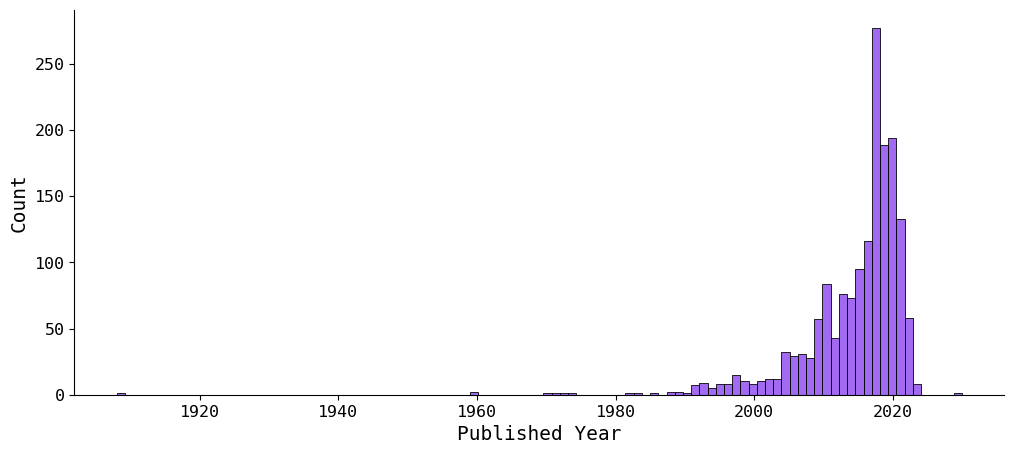

In [18]:
plt.figure(figsize=(12,5))
sns.histplot(data=pub_year, 
             x='Published_Year', 
#              bins=70,
             color=COLORS[3])
# plt.yscale('log')
plt.xlabel('Published Year', size=14)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
sns.despine(top=True, right=True)
plt.xticks(size=12)
sns.despine(top=True, right=True)
plt.show()

In [273]:
older_books = df_merge[df_merge.Published_Year<'2000']

# Most banned books overall across all districts
 
banned_books_older = older_books.Title.value_counts().reset_index()
banned_books_older.columns = ['Original_Title', 'count']
book_cols = ['Original_Title', 'Author_fullname', 'description', 'Published_Year', 
             'printType', 'pageCount', 'categories', 'maturityRating',
            'averageRating', 'ratingsCount', 'genre', 'age_group']
author_cols = ['author', 'ethnicity', 'gender']

banned_books_older = banned_books_older\
    .merge(book_metadata[book_cols], on='Original_Title', how='left')\
    .merge(author_metadata[author_cols], left_on='Author_fullname', right_on='author', how='left')

# banned_books
banned_books_older.head(20)

,Original_Title,count,Author_fullname,description,Published_Year,printType,pageCount,categories,maturityRating,averageRating,ratingsCount,genre,age_group,author,ethnicity,gender
0,The Bluest Eye,22,Toni Morrison,NATIONAL BESTSELLER • From the acclaimed Nobel...,1970,BOOK,226.0,['Fiction'],NOT_MATURE,3.5,138.0,Fiction,Adult,Toni Morrison,Black,F
1,Beloved,11,Toni Morrison,"Sethe, an escaped slave living in post-Civil W...",1987,BOOK,354.0,['African Americans'],NOT_MATURE,NaN,NaN,Nonfiction,Adult,Toni Morrison,Black,F
2,Lucky,6,Alice Sebold,An acclaimed journalist shares the gripping st...,2017,BOOK,288.0,['Biography & Autobiography'],NOT_MATURE,4.0,79.0,Nonfiction,Adult,Alice Sebold,UNK,F
3,Lucky,6,Alice Seabold,NaN,1908,BOOK,350.0,['Common fallacies'],NOT_MATURE,NaN,NaN,Nonfiction,Adult,Alice Seabold,UNK,F
4,Speak,6,Laurie Halse Anderson,The first ten lies they tell you in high schoo...,1999,BOOK,208.0,['Young Adult Fiction'],NOT_MATURE,4.0,407.0,Fiction,YA,Laurie Halse Anderson,UNK,F
5,Maus 1: A Survivor's Tale: My Father Bleeds Hi...,3,Art Spiegelman,The definitive edition of the graphic novel ac...,1996,BOOK,298.0,['Comics & Graphic Novels'],NOT_MATURE,4.5,123.0,Fiction,Adult,Art Spiegelman,UNK,M
6,Slaughterhouse-Five,2,Kurt Vonnegut Jr.,"Kurt Vonnegut’s masterpiece, Slaughterhouse-Fi...",1999,BOOK,285.0,['Fiction'],NOT_MATURE,4.0,1807.0,Fiction,Adult,Kurt Vonnegut Jr.,UNK,M
7,Jack,2,A. M. Homes,Fifteen-year-old Jack's confused feelings for ...,1989,BOOK,220.0,['Juvenile Fiction'],NOT_MATURE,4.0,6.0,Fiction,Juvenile,A. M. Homes,UNK,F
8,Encounter,2,Brittany Luby,A powerful imagining by two Native creators of...,2019,BOOK,40.0,['Juvenile Fiction'],NOT_MATURE,4.0,4.0,Fiction,Juvenile,Brittany Luby,UNK,F
9,Encounter,2,Jane Yolen,A Taino Indian boy on the island of San Salvad...,1996,BOOK,36.0,['Juvenile Fiction'],NOT_MATURE,5.0,1.0,Fiction,Juvenile,Jane Yolen,White,F


### Categories/Genres - Children/YA books, Fiction v nonfiction

Categories (Tagged by Google?). 34% books are Juvenile Fiction, 26% Young Adult, 11% Juvenile Nonfiction ...

In [23]:
all_categories = [i for sublist in [eval(cat) for cat in book_metadata[book_metadata.categories.notnull()].categories.values] for i in sublist]
for genre, count in Counter(all_categories).most_common(10):
    print(genre, '\t', count / len(book_metadata) * 100)
    

Juvenile Fiction 	 34.202546998180715
Young Adult Fiction 	 26.743480897513646
Juvenile Nonfiction 	 11.643420254699818
Fiction 	 5.45785324439054
Young Adult Nonfiction 	 2.850212249848393
Education 	 1.758641600970285
Comics & Graphic Novels 	 1.3947847180109159
Biography & Autobiography 	 1.3947847180109159
Social Science 	 1.2734990903577925
JUVENILE FICTION 	 0.8489993935718617


A lot of the books are labeled as juvenile (46%) or YA (30%) ... Majority of the banned books are fiction (almost 70%)

In [24]:
# How many are "Juvenile" or "Young Adult"?
def get_book_age_group(x):
    if pd.isna(x): return 'Other'
    if 'juvenile' in x.lower():
        return 'Juvenile'
    if 'young adult' in x.lower():
        return 'YA'
    else:
        return 'Adult'
    
def get_genre(x):
    if pd.isna(x): return 'Other'
    for f in ['nonfiction', 'history', 'biography', 'social science', 'education', 'family', 
              'health', 'art', 'african americans']:
        if f in x.lower():
            return 'Nonfiction'
    
    for f in ['fiction', 'comics']:
        if f in x.lower():
            return 'Fiction'
        
    if 'poetry' in x.lower():
        return 'Other'
    
    return 'Nonfiction'
    
book_metadata['genre'] = book_metadata.categories.apply(get_genre)
# book_metadata['genre'].value_counts(normalize=True)
book_metadata['age_group'] = book_metadata.categories.apply(get_book_age_group)
# book_metadata['age_group'].value_counts(normalize=True)

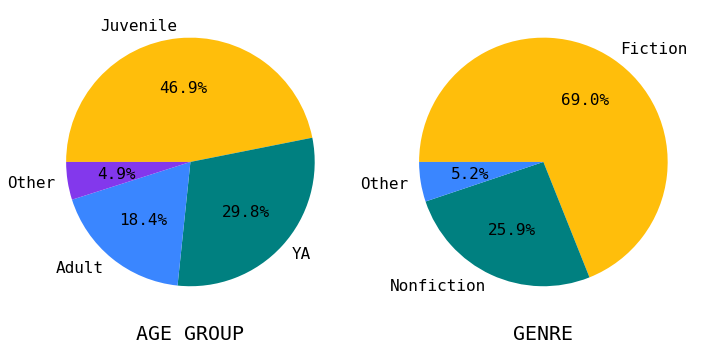

In [215]:
# https://stackoverflow.com/questions/14279344/how-can-i-add-textures-to-my-bars-and-wedges

# 3 pie charts - one for each GROUP -  Not self aware, Self aware, and US Adults 2022
fig, axes = plt.subplots(1,2, figsize=(10,5))

for ax, col_name in zip(axes, ['age_group', 'genre']):
    d = book_metadata[col_name].value_counts(normalize=True).reset_index()
    d.columns=[col_name, 'Percentage']
    d['label'] = d.apply(lambda x: f"{x[col_name]}(" + '{:.1%}'.format(x.Percentage) + ')', axis=1)
    
    patches, texts, autopcts = ax.pie(x=d.Percentage,
                                      startangle=180,
                                      labels=d[col_name],
                                      autopct='%1.1f%%', 
                                      colors=COLORS, 
                                      counterclock=False,
                                      textprops={'fontsize': 16}
                                     )
    plt.setp(autopcts, **{'fontsize':16})
    ax.set_xlabel(col_name.replace('_', ' ').upper(), size=20)
    
plt.tight_layout()


# plt.show()
# plt.savefig('img/pct_crying_per_city_combined.png', transparent=True, bbox_inches='tight')
# plt.show()

### Banned Books descriptions - Topic Modeling

In [1]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [ ]:
descriptions = book_metadata[book_metadata.description.notnull()].description
def clean_desc(x):
    if pd.isna(x): return []
    return clean_tokens(x.split())
book_metadata['clean_description'] = book_metadata.description.apply(clean_desc)


desc_toks = [i for sublist in descriptions for i in sublist.split()]
desc_toks = clean_tokens(desc_toks)

In [351]:
my_stop_words = list(text.ENGLISH_STOP_WORDS.union(["she's", "he's", "shes", "hes"]))
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words=my_stop_words)

topic_model2 = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=True,
    verbose=True
)
topics, probs = topic_model2.fit_transform(descriptions.values)

topic_model2.get_topic_info()



Batches:   0%|          | 0/51 [00:00<?, ?it/s]

2023-02-25 15:21:29,726 - BERTopic - Transformed documents to Embeddings
2023-02-25 15:21:38,177 - BERTopic - Reduced dimensionality
2023-02-25 15:21:38,658 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,820,-1_new_book_story_family
1,0,107,0_love_life_new_friend
2,1,88,1_boy_school_best_new
3,2,59,2_magic_fantasy_new_queen
4,3,54,3_gender_gay_transgender_lgbt
5,4,50,4_book_native_american_moon
6,5,43,5_love_story_life_girls
7,6,28,6_malala_hijab_book_story
8,7,28,7_students_schools_urban_education
9,8,27,8_movement_black_civil_civil rights


In [405]:
bookstopics = book_metadata[book_metadata.description.notnull()][['Author_lastname', 'Original_Title']]
bookstopics['Topic'] = topics

In [406]:
df_with_topics = df.Title.value_counts().reset_index()
df_with_topics.columns = ['Original_Title', 'count']
df_with_topics = df_with_topics.merge(bookstopics, on='Original_Title')
df_with_topics['Title_Author'] = df_with_topics['Original_Title'] + ' (' + df_with_topics['Author_lastname'] + ')'


In [408]:
for topic_num in [0,1,2,3,4,9,12,14]:
    print(f'Topic ({topic_num}):', topicmodel2labels[topic_num])
    for i in df_with_topics[df_with_topics.Topic==topic_num]['Title_Author'].head(10):
        print(i)
    print()

Topic (0): New/Love
The Truth About Alice: A Novel (Mathieu)
Speak (Anderson)
Blended (Draper)
Sloppy Firsts (Jessica Darling Series) (McCafferty)
The Upside of Unrequited (Simonverse Series) (Albertalli)
Odd One Out (Stone)
Ask the Passengers (King)
As I Descended (Talley)
If I Was Your Girl (Russo)
The Opposite of Innocent (Sones)

Topic (1): Boy/Gay
Thirteen Reasons Why (Asher)
Flamer (Curato)
Jack of Hearts (and other parts) (Rosen)
We Are the Ants (Hutchinson)
Cemetery Boys (Thomas)
Trans Mission: My Quest to a Beard (Bertie)
Geography Club (Russel Middlebrook Series) (Hartinger)
They Both Die at the End (Silvera)
Darius the Great Deserves Better (Darius the Great Series) (Khorram)
Class Act (Craft)

Topic (2): Gender/Transgender
City of Heavenly Fire (The Mortal Instruments Series) (Clare)
Ash (Lo)
Of Fire and Stars (Of Fire and Stars Series) (Coulthurst)
A Court of Frost and Starlight (A Court of Thorns and Roses Series) (Maas)
The Midnight Lie (Forgotten Gods Series) (Rutkoski)

Set custom labels and display them on the chart

In [252]:
topicmodel2labels = {
    0: "New/Love",
    1: "Boy/Gay",
    2: "Gender/Transgender",
    3: "Black/Racism",
    4: "Magic/Fantasy",
    9: "Muslim/Hijab",
    12: "Women/Science",
    14: "Abortion/Supreme Court"
}
topic_model2.set_topic_labels(topicmodel2labels)


In [253]:
fig = topic_model2.visualize_barchart(topics=[0,1,2,3,4,9,12,14], n_words=8, custom_labels=True, title='')
# fig.write_html("book_description_topic_model_selected.html")
fig

### The top banned books by state/location

Number of unique books banned per state (only showing states that banned more than 10 books)

> It is important to recognize that books available in schools, whether in a school or classroom library, or as part of a curriculum, were selected by librarians and educators as part of the educational offerings to students. Book bans occur when those choices are overridden by school boards, administrators, teachers, or even politicians, on the basis of a particular book’s content. The phrase “book ban” does not apply to initial decisions by a school district or school on which books to purchase or assign to students. It does not refer to situations in which educators initially determine that certain books are more appropriate for access at or above particular grade levels. Nor does it apply to situations where professional educators and administrators engage in regular curriculum review or updates and make decisions about which books will or will not be assigned in class. Likewise, if books are deaccessioned from libraries following best practices of collection maintenance and “weeding” that are content-neutral, and the result of regular updating, that is not a ban. A book ban occurs when an objection to the content of a specific book or type of book leads to that volume being withdrawn either fully or partially from availability, or when a blanket prohibition or absolute restriction is placed on a particular title.

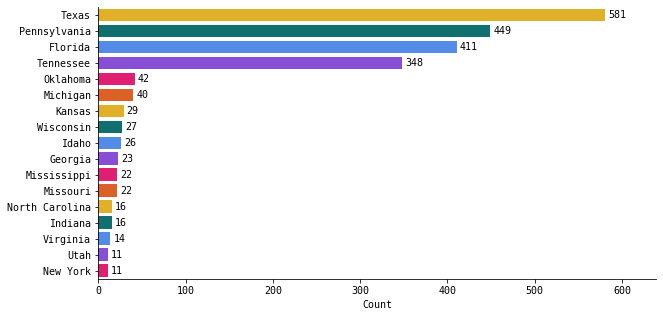

In [209]:
book_titles_by_state = df_merge.groupby('State')['Title'].nunique().sort_values(ascending=False).reset_index()
book_titles_by_state.columns=['State', 'Count']

ax = make_barchart(book_titles_by_state[book_titles_by_state.Count>10], x='Count', y='State')


Top 10 books that are banned in the most school districts

<AxesSubplot: xlabel='count'>

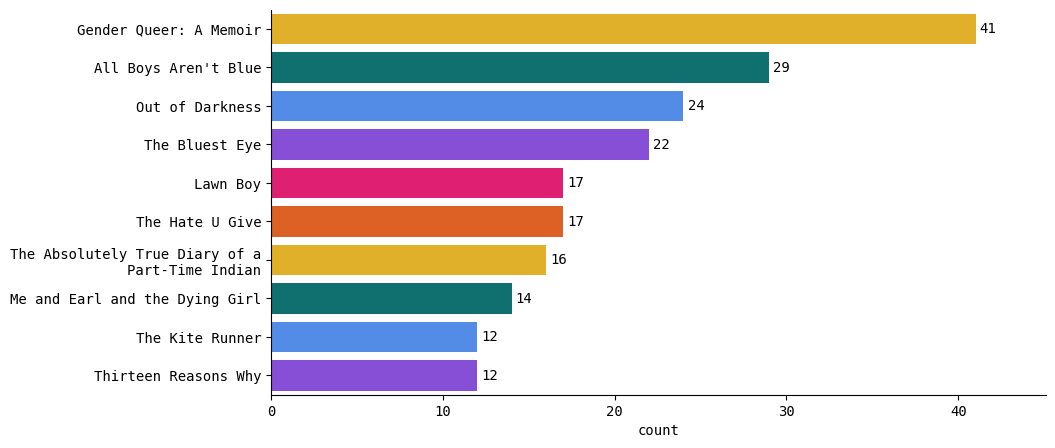

In [15]:
# Most banned books overall across all districts
 
banned_books = df.Title.value_counts().reset_index()
banned_books.columns = ['Original_Title', 'count']
book_cols = ['Original_Title', 'Author_fullname', 'description', 'Published_Year', 
             'printType', 'pageCount', 'categories', 'maturityRating',
            'averageRating', 'ratingsCount', 'genre', 'age_group']
author_cols = ['author', 'ethnicity', 'gender']

banned_books = banned_books\
    .merge(book_metadata[book_cols], on='Original_Title', how='left')\
    .merge(author_metadata[author_cols], left_on='Author_fullname', right_on='author', how='left')

# banned_books
make_barchart(banned_books.head(10), x='count', y='Original_Title')

In [246]:
len(book_metadata), len(author_metadata)

(1649, 1146)

In [244]:
for genre in ['Fiction', 'Nonfiction']:
    print(f'Top Banned {genre} Books')
    print('-'*30)
    rows = banned_books[banned_books.genre==genre].head()[['Original_Title', 'Author_fullname']]
    print('\n'.join(rows['Original_Title'] + ' (' + rows['Author_fullname'] + ')'))
    print()

for age_group in ['Juvenile', 'Adult']:
    print(f'Top Banned {age_group} Books')
    print('-'*30)
    rows = banned_books[banned_books.age_group==age_group].head()[['Original_Title', 'Author_fullname']]
    print('\n'.join(rows['Original_Title'] + ' (' + rows['Author_fullname'] + ')'))
    print()


Top Banned Fiction Books
------------------------------
Gender Queer: A Memoir (Maia Kobabe)
Out of Darkness (Ashley Hope Pérez)
The Bluest Eye (Toni Morrison)
Lawn Boy (Jonathan Evison)
The Hate U Give (Angie Thomas)

Top Banned Nonfiction Books
------------------------------
All Boys Aren't Blue (George M. Johnson)
Beyond Magenta: Transgender Teens Speak Out (Susan Kuklin)
This Book Is Gay (Juno Dawson)
Beloved (Toni Morrison)
Fun Home: A Family Tragicomic (Alison Bechdel)

Top Banned Juvenile Books
------------------------------
Out of Darkness (Ashley Hope Pérez)
Me and Earl and the Dying Girl (Jesse Andrews)
Crank (Crank Series) (Ellen Hopkins)
This One Summer (Mariko Tamaki)
Drama: A Graphic Novel (Raina Telgemeier)

Top Banned Adult Books
------------------------------
Gender Queer: A Memoir (Maia Kobabe)
The Bluest Eye (Toni Morrison)
Lawn Boy (Jonathan Evison)
The Kite Runner (Khaled Hosseini)
Beloved (Toni Morrison)



/Users/yenniejun/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


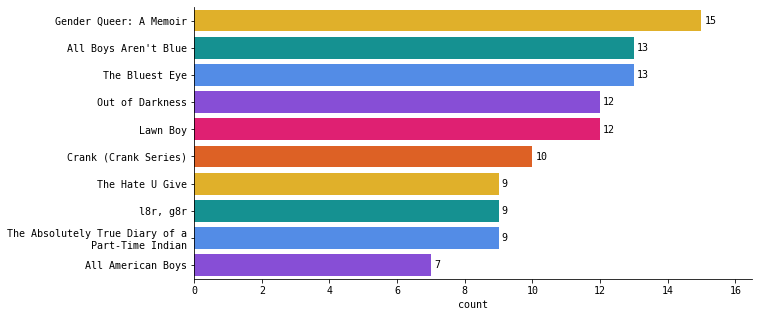

In [1498]:
# Unique books banned per state
# How many states is each book banned in?
banned_books_by_state = df.drop_duplicates(['State', 'Title', 'Author'])
 
banned_books_by_state = banned_books_by_state.Title.value_counts().head(10).reset_index()
banned_books_by_state.columns = ['Original_Title', 'count']
book_cols = ['Original_Title', 'Author_fullname', 'description', 'Published_Year', 
             'printType', 'pageCount', 'categories', 'maturityRating',
            'averageRating', 'ratingsCount']
author_cols = ['author', 'ethnicity', 'gender']

banned_books_by_state = banned_books_by_state\
    .merge(book_metadata[book_cols], on='Original_Title', how='left')\
    .merge(author_metadata[author_cols], left_on='Author_fullname', right_on='author', how='left')

# banned_books_by_state
make_barchart(banned_books_by_state, x='count', y='Original_Title')

## Looking at the top 10 most banned books, take those descriptions, and ask GPT-3 / ChatGPT / Bing

Asking the following to ChatGPT:

```
The following is a description for a book. Make a Markdown table, one column for ages {3, 5, 7, 9, 11, 13, 15, 17, 19, 21}. Write Yes or No whether you would ban the book for a classroom filled with students of that corresponding age.

{book description}
```

In [25]:
book_descriptions = {
    'gender_queer': """The author's intensely cathartic autobiography charts eir journey of self-identity, which includes the mortification and confusion of adolescent crushes, grappling with how to come out to family and society, bonding with friends over erotic gay fanfiction, and facing the trauma and fundamental violation of pap smears.""",
    'all_boys_arent_blue': """In a series of personal essays, the author explores his childhood, adolescence, and college years in New Jersey and Virginia. From the memories of getting his teeth kicked out by bullies at age five, to flea marketing with his loving grandmother, to his first sexual relationships, this young-adult memoir weaves together the trials and triumphs faced by Black queer boys.""",
    'out_of_darkness': """The novel chronicles a love affair between a teenage Mexican American girl and a teenage African-American boy in 1930's New London, Texas, occuring right up to the 1937 New London School explosion.""",
    'bluest_eye': """An 11-year-old Black girl in an America whose love for its blond, blue-eyed children can devastate all others prays for her eyes to turn blue: so that she will be beautiful, so that people will look at her, so that her world will be different. This is the story of the nightmare at the heart of her yearning, and the tragedy of its fulfillment""",
    "lawn_boy": """A semi-autobiographical coming-of-age novel that tells the story of a young adult Mexican American who has faced hardship ever since his childhood and is now going through a phase of self-discovery."""
}

### Making data

In [ ]:
def make_prompt(desc, age=None):
    if age:
        prompt = f"Given the following description of a book, would you recommend this to a classroom of {age}-year-olds?\n\nDescription: "
    else:
        prompt = f"Given the following description of a book, would you recommend this to a classroom?\n\nDescription: "

    
    prompt += desc
    prompt += "\n\nGive your answer (Answer:) then explain your decision (Explain:)."
    
    return prompt
    
def make_prompt_book_author(book, author, age=None):
    prompt = f"""Would you recommend the book "{book}" by {author} to a classroom"""
    if age:
        prompt += f" of {age}-year-olds?"
    else:
        prompt += "?"
    
    prompt += "\nGive your answer (Answer:) then explain your decision (Explain:)."
    
    return prompt

def make_prompt_ban_book(desc, age=None):
    if age:
        prompt = f"Given the following description of a book, would you ban this book for a classroom of {age}-year-olds?\n\nDescription: "
    else:
        prompt = f"Given the following description of a book, would you ban this book?\n\nDescription: "

    
    prompt += desc
    prompt += "\n\nGive your answer (Answer:) then explain your decision (Explain:)."
    
    return prompt

def make_prompt_book_author_ban_book(book, author, age=None):
    prompt = f"""Would you ban the book "{book}" by {author} in a classroom"""
    if age:
        prompt += f" of {age}-year-olds?"
    else:
        prompt += "?"
    
    prompt += "\nGive your answer (Answer:) then explain your decision (Explain:)."
    
    return prompt

In [479]:
make_prompt_ban_book('Gender Queer', 3)

'Given the following description of a book, would you ban this book for a classroom of 3-year-olds?\n\nDescription: Gender Queer\n\nGive your answer (Answer:) then explain your decision (Explain:).'

In [253]:
print(make_prompt_book_author('Gender Queer', 'Maia Kobabe', 3))

Would you recommend the book "Gender Queer" by Maia Kobabe to a classroom of 3-year-olds?
Give your answer (Answer:) then explain your decision (Explain:).


In [18]:
# Would you RECOMMEND A BOOK with the DESCRIPTION for a clasroom...
responses = []

for age in tqdm.tqdm(range(3, 23, 2)):
    for book in book_descriptions.keys():
    
        prompt = make_prompt(book_descriptions[book], age=age)

        response = openai.Completion.create(model="text-davinci-003", 
                                            prompt=prompt, 
                                            n=5,
                                            max_tokens=256
                                          )
        for res in response['choices']:
            responses.append({
                'book': book,
                'age': age,
                'model': 'gpt3',
                'response': res['text'],
            })

        time.sleep(3)

with open('gpt3_banned_books_responses.json', 'w') as fp:
    json.dump(responses, fp)

100%|███████████████████████████████████████████| 10/10 [06:21<00:00, 38.20s/it]


In [21]:
# Would you RECOMMEND A BOOK with the TITLE,AUTHOR for a clasroom...
responses = []

for age in tqdm.tqdm(range(3, 23, 2)):
    for _, (_book, _author) in banned_books[['Original_Title', 'Author_fullname']].head().iterrows():

        prompt = make_prompt_book_author(_book, _author, age=age)

        response = openai.Completion.create(model="text-davinci-003", 
                                            prompt=prompt, 
                                            n=5,
                                            max_tokens=256
                                          )
        for res in response['choices']:
            responses.append({
                'book': _book,
                'author': _author,
                'age': age,
                'model': 'gpt3',
                'response': res['text'],
            })

        time.sleep(3)

with open('gpt3_banned_books_title_author_responses.json', 'w') as fp:
    json.dump(responses, fp)

100%|███████████████████████████████████████████| 10/10 [06:21<00:00, 38.17s/it]


In [ ]:
# Would you BAN A BOOK with the DESCRIPTION for a classroom...
responses = []

for age in tqdm.tqdm(range(3, 23, 2)):
    for book in book_descriptions.keys():
    
        prompt = make_prompt_ban_book(book_descriptions[book], age=age)

        response = openai.Completion.create(model="text-davinci-003", 
                                            prompt=prompt, 
                                            n=5,
                                            max_tokens=256
                                          )
        for res in response['choices']:
            responses.append({
                'book': book,
                'age': age,
                'model': 'gpt3',
                'response': res['text'],
            })

        time.sleep(3)

with open('gpt3_banned_books_responses_wouldyoubanbook.json', 'w') as fp:
    json.dump(responses, fp)

In [19]:
# Would you BAN A BOOK with the TITLE,AUTHOR for a clasroom...
responses = []

for age in tqdm.tqdm(range(3, 23, 2)):
    for _, (_book, _author) in banned_books[['Original_Title', 'Author_fullname']].head().iterrows():

        prompt = make_prompt_book_author_ban_book(_book, _author, age=age)

        response = openai.Completion.create(model="text-davinci-003", 
                                            prompt=prompt, 
                                            n=5,
                                            max_tokens=256
                                          )
        for res in response['choices']:
            responses.append({
                'book': _book,
                'author': _author,
                'age': age,
                'model': 'gpt3',
                'response': res['text'],
            })

        time.sleep(3)

with open('gpt3_banned_books_title_author_responses_wouldyoubanbook.json', 'w') as fp:
    json.dump(responses, fp)

100%|███████████████████████████████████████████| 10/10 [07:27<00:00, 44.77s/it]


In [26]:
def clean_answer(x):
    if 'Answer' not in x: 
        cleaned_answer = x.split(',')[0].strip()
    else:
        cleaned_answer = x.split('Answer:')[1].replace('.', '').strip()
        
    if ','  in cleaned_answer:
        return cleaned_answer.split(',')[0].strip()
    else: return cleaned_answer
    
def clean_explanation(x):
    if 'Explain' not in x:
        return x
    else:
        return x.split('Explain:')[1].strip()

### Analysis for "Would you ban a book..."

In [13]:
# Giving GPT3 the title+author of the book
ban_title = pd.read_json('gpt3_banned_books_title_author_responses_wouldyoubanbook.json')
ban_title['answer'] = ban_title['response'].apply(lambda x: x.split('\nExplain')[0])
ban_title['answer'] = ban_title['answer'].apply(clean_answer)
ban_title['explain'] = ban_title['response'].apply(clean_explanation)

# Giving GPT3 the description of the book
ban_description = pd.read_json('gpt3_banned_books_responses_wouldyoubanbook.json')
ban_description['answer'] = ban_description['response'].apply(lambda x: x.split('\nExplain')[0])
ban_description['answer'] = ban_description['answer'].apply(clean_answer)
ban_description['explain'] = ban_description['response'].apply(clean_explanation)
temptitle2title = {k:v for k, v in zip(book_descriptions.keys(), ban_title.book.unique())}
ban_description.book = ban_description.book.apply(lambda x: temptitle2title[x])



In [106]:
data_mode_pivot.columns

Int64Index([3, 5, 7, 9, 11, 13, 15, 17, 19, 21], dtype='int64', name='age')

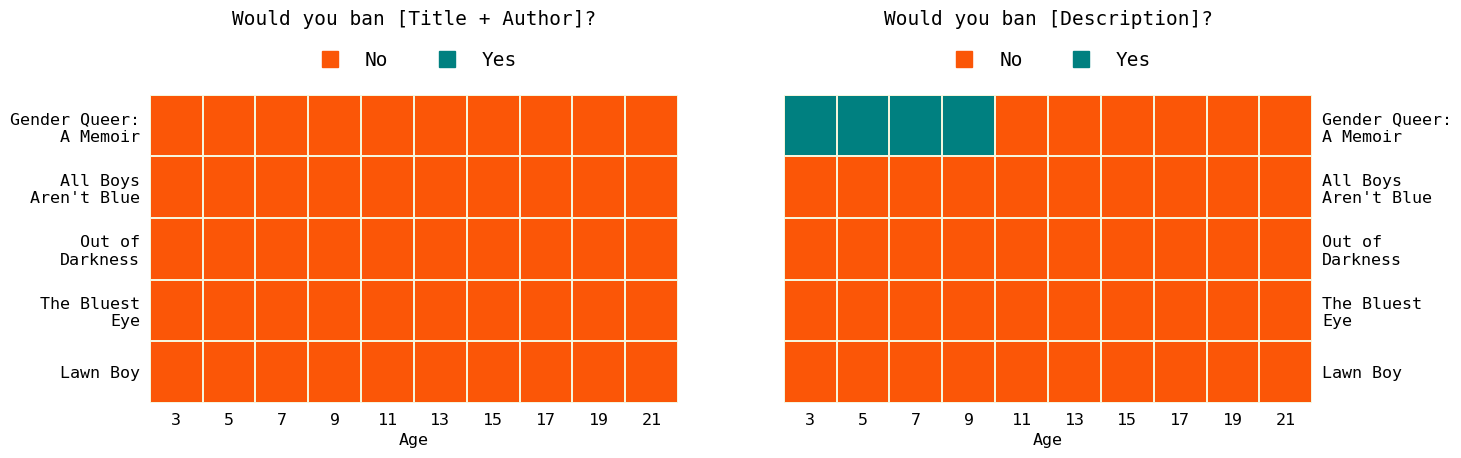

In [123]:
fig, axes = plt.subplots(1,2, figsize=(15,4))

for ax, data_mode_pivot, plot_title in zip(axes, 
                                           [data_mode_pivot_title, data_mode_pivot_description], 
                                           ['Title + Author', 'Description']):

    sns.heatmap(data_mode_pivot,
#                 square=True,
                cbar=False,
                cmap=[COLORS[5], COLORS[1]],
                linewidths=.2,
                linecolor='beige',
                ax=ax
               )
    ax.set_ylabel('')
    
    ax.set_yticklabels(data_mode_pivot.index, fontsize=12)
 

#     ax.set_tick_params(left=False, bottom=False)
    ax.set_xticklabels(data_mode_pivot.columns, fontsize=12)
    ax.set_xlabel('Age', size=12)
    wrap_labels(ax, 13)
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')


    no = mlines.Line2D([], [], color=COLORS[5], marker='s', ls='', label='No')
    yes = mlines.Line2D([], [], color=COLORS[1], marker='s', ls='', label='Yes')
    ax.legend(handles=[no,yes], loc='upper center', 
               bbox_to_anchor=(0.5, 1.2), 
               ncol=2, 
               frameon=False,
               fontsize=14,
               markerscale=2,
              )
    
    ax.set_title(f'Would you ban [{plot_title}]?', y=1.2, size=14)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('none')

### Topic Modeling using GPT "ban book" response

In [18]:
ban_description['answer_binary'] = ban_description['answer'].apply(lambda x: 0 if x=='No' else 1)

In [23]:
my_stop_words = list(text.ENGLISH_STOP_WORDS\
                     .union(["she's", "he's", "shes", "hes", 'book', 'classroom'])\
                     .union([f'{i}yearold' for i in range(3,23, 2)])\
                     .union([f'{i}yearolds' for i in range(3,23, 2)])
                    )
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words=my_stop_words)

tm_ban_description = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=True,
    verbose=True,
)
topics_ban_description, probs = tm_ban_description.fit_transform(
    ban_description.explain.values,
    y=ban_description['answer_binary']
)

tm_ban_description.get_topic_info()


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2023-03-01 11:13:04,625 - BERTopic - Transformed documents to Embeddings
2023-03-01 11:13:08,650 - BERTopic - Reduced dimensionality
2023-03-01 11:13:08,677 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,1,-1_adult parse_themes beauty standards racial_...
1,0,126,0_sounds like_important topics_does contain_pr...
2,1,36,1_important themes_provide important_does cont...
3,2,24,2_does contain_language content_age group_matu...
4,3,19,3_older children_contain mature_does contain_m...
5,4,18,4_does contain_contain content_content suitabl...
6,5,14,5_black queer_black queer boys_queer boys_quee...
7,6,12,6_crushes coming_topics discussed_age group_ma...


In [24]:
fig = tm_ban_description.visualize_barchart(n_words=8)
fig.write_html("tm_ban_description-gpt.html")
fig

### Analysis for "Would you recommend a book..."

In [80]:
# Giving GPT3 the description of the book
responses_df = pd.read_json('gpt3_banned_books_responses.json')
responses_df['answer'] = responses_df['response'].apply(lambda x: x.split('\nExplain')[0])
responses_df['answer'] = responses_df['answer'].apply(clean_answer)
responses_df['explain'] = responses_df['response'].apply(clean_explanation)
# responses_df = responses_df.drop(columns='response')

In [126]:
# Giving GPT3 the title+author of the book
rec_title = pd.read_json('gpt3_banned_books_title_author_responses.json')
rec_title['answer'] = rec_title['response'].apply(lambda x: x.split('\nExplain')[0])
rec_title['answer'] = rec_title['answer'].apply(clean_answer)
rec_title['explain'] = rec_title['response'].apply(clean_explanation)

# Giving GPT3 the description of the book
rec_description = pd.read_json('gpt3_banned_books_responses.json')
rec_description['answer'] = rec_description['response'].apply(lambda x: x.split('\nExplain')[0])
rec_description['answer'] = rec_description['answer'].apply(clean_answer)
rec_description['explain'] = rec_description['response'].apply(clean_explanation)
temptitle2title = {k:v for k, v in zip(book_descriptions.keys(), rec_title.book.unique())}
rec_description.book = rec_description.book.apply(lambda x: temptitle2title[x])

data_mode = rec_description.groupby(['book', 'age'])['answer'].agg(scipy.stats.mode).reset_index()
data_mode.answer = data_mode.answer.apply(lambda x: x[0][0])
data_mode['answer_map'] = data_mode.answer.apply(lambda x: 0 if x=='No' else 1)
# data_mode.groupby('age').answer.value_counts(normalize=True)*100
data_mode_pivot_description_rec = data_mode.pivot(index='book', columns='age', values='answer_map')\
    .reindex(ban_title.book.unique())


data_mode = rec_title.groupby(['book', 'age'])['answer'].agg(scipy.stats.mode).reset_index()
data_mode.answer = data_mode.answer.apply(lambda x: x[0][0])
data_mode['answer_map'] = data_mode.answer.apply(lambda x: 0 if x=='No' else 1)
# data_mode.groupby('age').answer.value_counts(normalize=True)*100
data_mode_pivot_title_rec = data_mode.pivot(index='book', columns='age', values='answer_map')\
    .reindex(rec_title.book.unique())


/Users/yenniejun/anaconda3/envs/nlp/lib/python3.8/site-packages/pandas/core/groupby/groupby.py:1160: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  f = lambda x: func(x, *args, **kwargs)


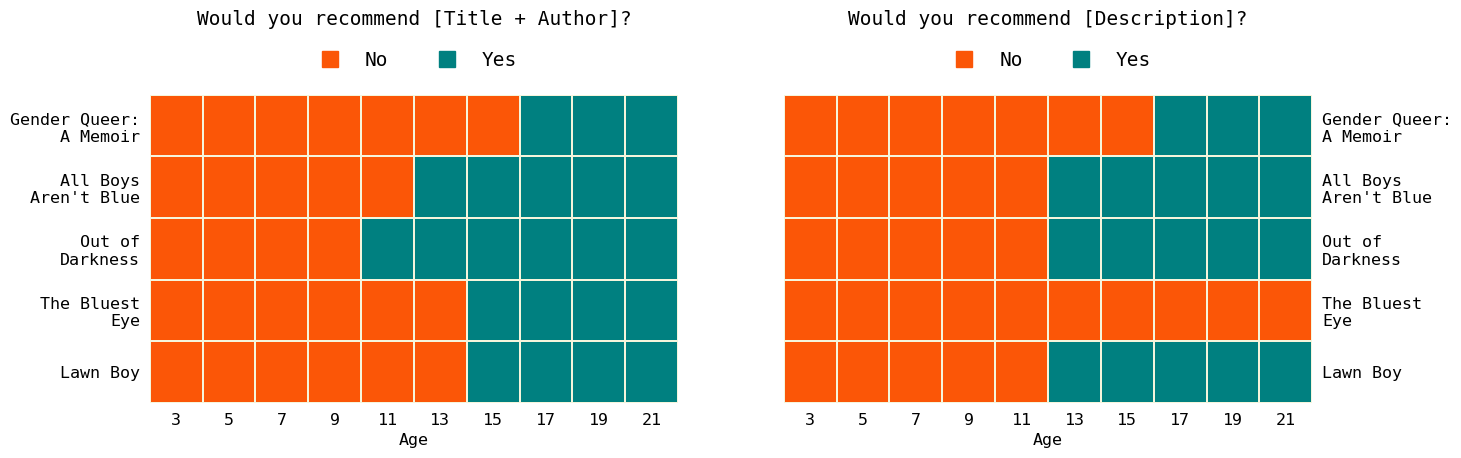

In [127]:
fig, axes = plt.subplots(1,2, figsize=(15,4))

for ax, data_mode_pivot, plot_title in zip(axes, 
                                           [data_mode_pivot_title_rec, data_mode_pivot_description_rec], 
                                           ['Title + Author', 'Description']):

    sns.heatmap(data_mode_pivot,
                cbar=False,
                cmap=[COLORS[5], COLORS[1]],
                linewidths=.2,
                linecolor='beige',
                ax=ax
               )
    ax.set_ylabel('')
    
    ax.set_yticklabels(data_mode_pivot.index, fontsize=12)
 

#     ax.set_tick_params(left=False, bottom=False)
    ax.set_xticklabels(data_mode_pivot.columns, fontsize=12)
    ax.set_xlabel('Age', size=12)
    wrap_labels(ax, 13)
    
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')


    no = mlines.Line2D([], [], color=COLORS[5], marker='s', ls='', label='No')
    yes = mlines.Line2D([], [], color=COLORS[1], marker='s', ls='', label='Yes')
    ax.legend(handles=[no,yes], loc='upper center', 
               bbox_to_anchor=(0.5, 1.2), 
               ncol=2, 
               frameon=False,
               fontsize=14,
               markerscale=2,
              )
    
    ax.set_title(f'Would you recommend [{plot_title}]?', y=1.2, size=14)

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('none')

### Topic modeling using GPT "recommend book" response

In [96]:
my_stop_words = list(text.ENGLISH_STOP_WORDS\
                     .union(["she's", "he's", "shes", "hes", 'book', 'classroom'])\
                     .union([f'{i}yearold' for i in range(3,23, 2)])\
                     .union([f'{i}yearolds' for i in range(3,23, 2)])
                    )
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words=my_stop_words)

gpt_response_topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=True,
    verbose=True
)
topics, probs = gpt_response_topic_model.fit_transform(responses_df.explain.values)

gpt_response_topic_model.get_topic_info()


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2023-02-24 20:35:13,285 - BERTopic - Transformed documents to Embeddings
2023-02-24 20:35:15,829 - BERTopic - Reduced dimensionality
2023-02-24 20:35:15,849 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,7,-1_mexican_mexican american_american_insight
1,0,52,0_topics_experiences_themes_students
2,1,47,1_historical_topics_themes_provides
3,2,27,2_mature_contains_likely_topics
4,3,25,3_appropriate_audience_mature_topics
5,4,25,4_mature_likely_contains_topics
6,5,25,5_mature_content_themes_likely
7,6,22,6_mature_themes_older_topics
8,7,20,7_black_queer_black queer_boy


In [97]:
fig = gpt_response_topic_model.visualize_barchart(n_words=8)
fig.write_html("gpt_response_topic_model-tm.html")
fig

In [103]:
my_stop_words = list(text.ENGLISH_STOP_WORDS\
                     .union(["she's", "he's", "shes", "hes", 'book', 'classroom'])\
                     .union([f'{i}yearold' for i in range(3,23, 2)])\
                     .union([f'{i}yearolds' for i in range(3,23, 2)])
                    )
# we add this to remove stopwords
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words=my_stop_words)

gpt_response_topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language='english', 
    calculate_probabilities=True,
    verbose=True
)
topics, probs = gpt_response_topic_model.fit_transform(responses_df.explain.values, 
                                                       y=responses_df.answer.apply(lambda x: 0 if x=='No' else 1).values)

gpt_response_topic_model.get_topic_info()


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

2023-02-24 20:37:31,739 - BERTopic - Transformed documents to Embeddings
2023-02-24 20:37:34,649 - BERTopic - Reduced dimensionality
2023-02-24 20:37:34,684 - BERTopic - Clustered reduced embeddings


,Topic,Count,Name
0,-1,10,-1_mexican american_mexican_american_insight
1,0,35,0_mature_themes_difficult_content
2,1,32,1_relevant_experiences_identity_selfdiscovery
3,2,27,2_mature_contains_likely_topics
4,3,26,3_mature_content_likely_topics
5,4,25,4_historical_interracial_provides_novel
6,5,25,5_appropriate_audience_mature_topics
7,6,25,6_mature_likely_contains_content
8,7,23,7_black_queer_black queer_experiences
9,8,22,8_mature_themes_older_age


In [104]:
fig = gpt_response_topic_model.visualize_barchart(n_words=8)
fig.write_html("gpt_response_topic_model-tm_selfsupervised.html")
fig

#### Word Cloud

In [215]:
no_tokens = responses_df[responses_df.answer=='No'].explain
no_tokens = [i for sublist in no_tokens for i in sublist.split()]
no_tokens = clean_tokens(no_tokens)

In [220]:
_ngrams = get_ngrams(no_tokens, 2)
Counter(_ngrams).most_common(10)

[(('book', 'may'), 43),
 (('age', 'group'), 34),
 (('may', 'mature'), 28),
 (('older', 'audience'), 24),
 (('subject', 'matter'), 24),
 (('book', 'contains'), 21),
 (('likely', 'mature'), 19),
 (('mature', 'classroom'), 19),
 (('book', 'likely'), 18),
 (('audience', 'book'), 17)]

In [221]:
_ngrams = get_ngrams(no_tokens, 3)
Counter(_ngrams).most_common(10)

[(('age', 'group', 'book'), 15),
 (('older', 'audience', 'book'), 10),
 (('suited', 'older', 'audience'), 9),
 (('book', 'may', 'contain'), 9),
 (('better', 'suited', 'older'), 8),
 (('would', 'recommend', 'book'), 8),
 (('book', 'contains', 'mature'), 7),
 (('coming', 'family', 'society'), 7),
 (('may', 'mature', 'classroom'), 7),
 (('mature', 'age', 'group'), 6)]

In [226]:
from wordcloud import WordCloud, STOPWORDS
customStopwords=list(STOPWORDS) + ['may']

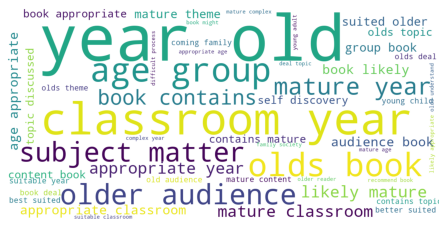

In [242]:
wordcloud = WordCloud(
    stopwords=customStopwords,
    collocation_threshold = 3,
    background_color ='white',
    max_words=2000,
    scale=3,
    min_font_size = 5
)\
.generate(" ".join(no_tokens))

plt.imshow(wordcloud)
plt.axis('off')
    
plt.tight_layout(pad = 0)
plt.show()

Bing's responses
- Gender Queer: "Based on the description you provided, I would not recommend this book to a classroom unless it is for mature students who are interested in topics such as self-identity, sexuality, and trauma. The description suggests that the book contains explicit and sensitive content that may not be suitable for younger or more conservative audiences. The description also does not clearly convey the genre, tone, or theme of the book."

### ChatGPT

The following is a description for a book. Make a Markdown table, one column for ages {3, 5, 7, 9, 11, 13, 15, 17, 19, 21}. Write whether you would recommend this book (Yes) or not (No) for a classroom filled with students of that corresponding age. Write another column with a short reason why or why not you would ban.

“An autobiography … which includes the mortification and confusion of adolescent crushes, grappling with how to come out to family and society, bonding with friends over erotic gay fanfiction, and facing the trauma and fundamental violation of pap smears”

Gender Queer
`The book description includes topics related to adolescent crushes, coming out, and sexual health, which are important subjects for young adults to learn about. While the subject matter may not be appropriate for younger children, there is no reason to ban the book for any of the age groups listed. The book's content is more suitable for older readers who are beginning to navigate similar issues in their own lives.`
No for everything



In [410]:
chat_gpt = {
    'gender_queer': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'No',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'all_boys_arent_blue': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'No',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'out_of_darkness': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'Yes',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'bluest_eye': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'Yes',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'lawn_boy': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'Yes',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    }

}



bing = {
    'gender_queer': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'No',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'all_boys_arent_blue': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'No',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'out_of_darkness': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'No',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'bluest_eye': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'Yes',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    },
    'lawn_boy': {
        3: 'No',
        5: 'No',
        7: 'No',
        9: 'No',
        11: 'Yes',
        13: 'Yes',
        15: 'Yes',
        17: 'Yes',
        19: 'Yes',
        21: 'Yes'
    }

}

In [443]:
chatgpt_pivot = pd.DataFrame(chat_gpt)
for c in chatgpt_pivot.columns:
    chatgpt_pivot[c] = chatgpt_pivot[c].apply(lambda x: 0 if x=='No' else 1)

chatgpt_pivot.columns = [i.replace('_', ' ').title() for i in chatgpt_pivot.columns]
chatgpt_pivot = chatgpt_pivot.T

bing_pivot = pd.DataFrame(bing)
for c in bing_pivot.columns:
    bing_pivot[c] = bing_pivot[c].apply(lambda x: 0 if x=='No' else 1)

bing_pivot.columns = [i.replace('_', ' ').title() for i in bing_pivot.columns]
bing_pivot = bing_pivot.T
bing_pivot

,3,5,7,9,11,13,15,17,19,21
Gender Queer,0,0,0,0,0,1,1,1,1,1
All Boys Arent Blue,0,0,0,0,0,1,1,1,1,1
Out Of Darkness,0,0,0,0,0,1,1,1,1,1
Bluest Eye,0,0,0,0,1,1,1,1,1,1
Lawn Boy,0,0,0,0,1,1,1,1,1,1


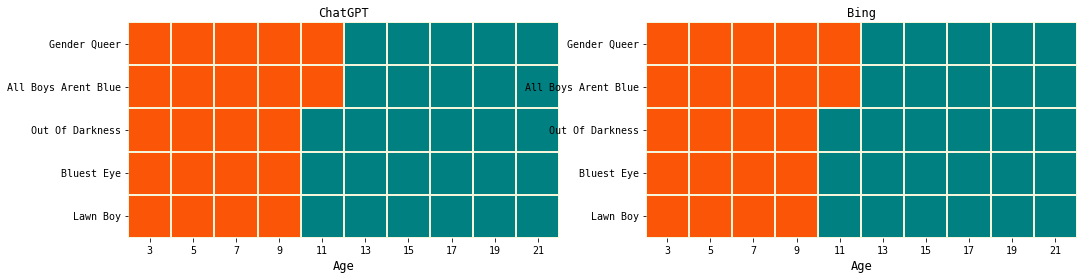

In [461]:
fig, axes = plt.subplots(1,2, figsize=(17, 5))

for ax, chatbot_df, chatbot_name in zip(axes, [chatgpt_pivot, bing_pivot], ['ChatGPT', 'Bing']):
    sns.heatmap(
        ax=ax,
        data=chatgpt_pivot,
        square=True,
        cbar=False,
        cmap=[COLORS[5], COLORS[1]],
        linewidths=.2,
        linecolor='beige',
        )
    ax.set_ylabel('')
#     ax.set_yticks(size=12)
#     ax.set_tick_params(left=False, bottom=False)
#     ax.set_xticks(size=12)
    ax.set_xlabel('Age', size=12)

    no = mlines.Line2D([], [], color=COLORS[5], marker='s', ls='', label='No')
    yes = mlines.Line2D([], [], color=COLORS[1], marker='s', ls='', label='Yes')

    ax.set_title(chatbot_name)


Text(0.5, 1.2, 'ChatGPT / Bing')

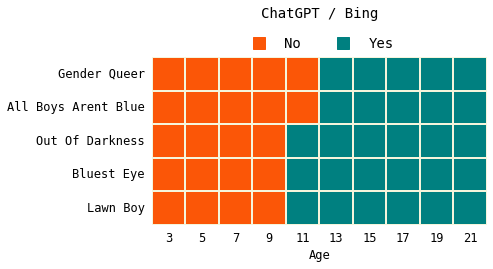

In [462]:
sns.heatmap(chatgpt_pivot,
            square=True,
            cbar=False,
            cmap=[COLORS[5], COLORS[1]],
            linewidths=.2,
            linecolor='beige',
           )
plt.ylabel('')
plt.yticks(size=12)
plt.tick_params(left=False, bottom=False)
plt.xticks(size=12)
plt.xlabel('Age', size=12)

import matplotlib.lines as mlines
no = mlines.Line2D([], [], color=COLORS[5], marker='s', ls='', label='No')
yes = mlines.Line2D([], [], color=COLORS[1], marker='s', ls='', label='Yes')
plt.legend(handles=[no,yes], loc='upper center', 
           bbox_to_anchor=(0.5, 1.2), 
           ncol=2, 
           frameon=False,
           fontsize=14,
           markerscale=2,
          )
plt.title('ChatGPT / Bing', y=1.2, size=14)


## Author analysis

The most commonly banned authors, across all districts

In [111]:
banned_authors = df.Author.value_counts().head(20).reset_index()
banned_authors.columns = ['author', 'count']
banned_authors['author'] = banned_authors.author.apply(lambda x: ' '.join(x.split(',')[::-1]).strip())
banned_authors = banned_authors.merge(author_metadata, on='author', how='left')
banned_authors = banned_authors[['author', 'gender', 'ethnicity', 'count']]
banned_authors['gender_and_eth'] = banned_authors.apply(lambda x: f"{x.ethnicity} ({x.gender})", axis=1)
banned_authors

,author,gender,ethnicity,count,gender_and_eth
0,Ellen Hopkins,F,White,43,White (F)
1,Maia Kobabe,NB,White,41,White (NB)
2,Toni Morrison,F,Black,34,Black (F)
3,George M. Johnson,NB,Black,30,Black (NB)
4,Lauren Myracle,F,White,29,White (F)
5,Ashley Hope Pérez,F,White,23,White (F)
6,Angie Thomas,F,Black,19,Black (F)
7,Sarah J. Maas,F,White,18,White (F)
8,Jason Reynolds,M,Black,18,Black (M)
9,Saadia Faruqi,F,Pakistani,17,Pakistani (F)


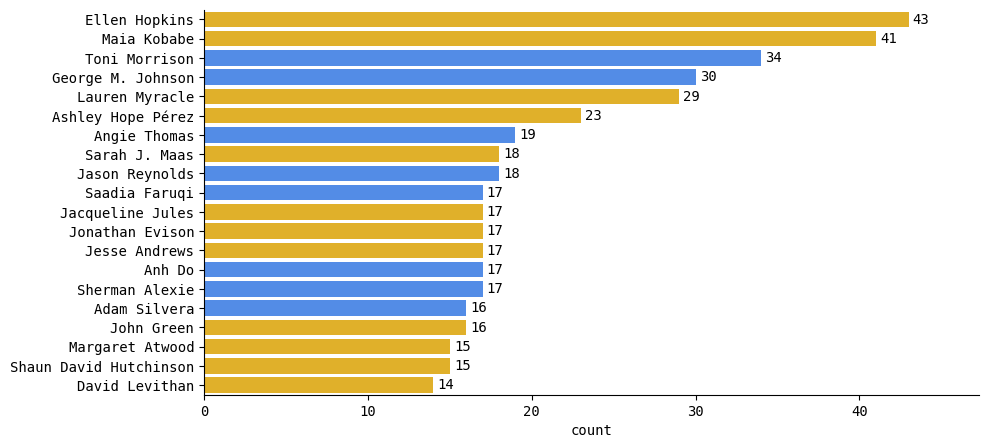

In [137]:

poc_colors = [COLORS[0] if i == 'White' else COLORS[2] for i in banned_authors.ethnicity]
make_barchart(banned_authors, x='count', y='author', palette=poc_colors)




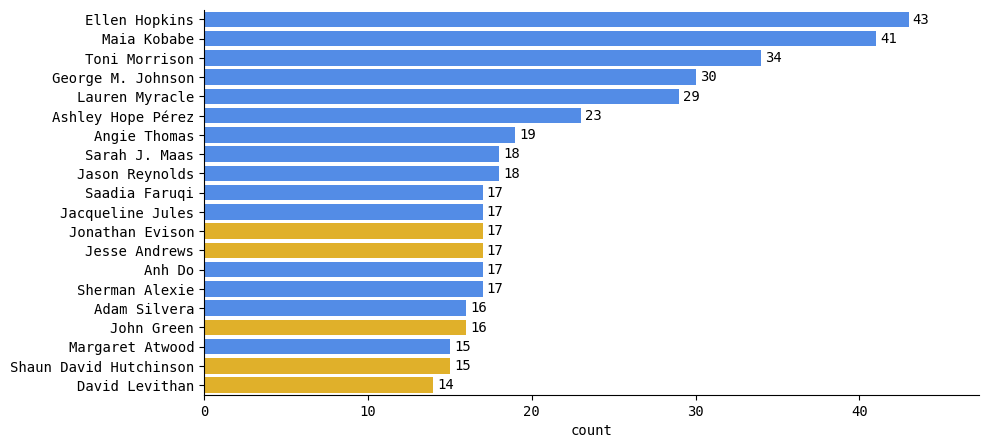

In [134]:

whiteman_colors = [COLORS[0] if i == 'White (M)' else COLORS[2] for i in banned_authors.gender_and_eth]
make_barchart(banned_authors, x='count', y='author', palette=whiteman_colors)



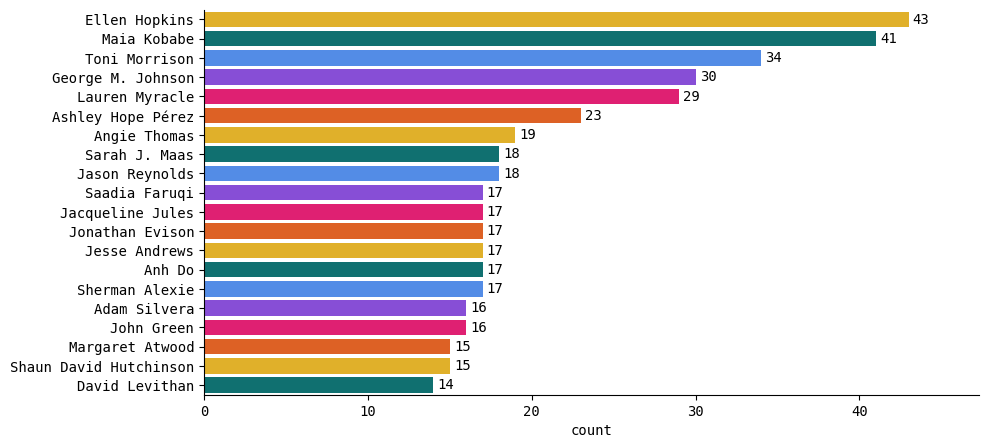

In [112]:
make_barchart(banned_authors, x='count', y='author')

Of the top 10 banned authors, 60% identify as women, 20% as NB, 20% as men

In [115]:
banned_authors.gender.value_counts()

F     9
M     9
NB    2
Name: gender, dtype: int64

In [114]:
# 40% are Black
banned_authors.ethnicity.value_counts()

White              12
Black               4
native american     1
Asian               1
POC                 1
Pakistani           1
Name: ethnicity, dtype: int64

 In fact, of the top 10 banned authors, only 1 is a White man (Jonathan Eviston). The others are women, nonbinary, and/or POC.
 
 Whereas, what about NYT bestseller list for last 10 years? Top 10 authors/top 10 books? Top 10 NYT bestseller books by what peopl?

In [116]:
# 20% are Black women, 30% are POC / non male, 
# Only 1/10 is a White man
# Everyone else is POC or woman or nonbinary
# Pretty low percentage that only 1 
banned_authors[['gender', 'ethnicity']].value_counts()

gender  ethnicity      
F       White              6
M       White              5
F       Black              2
        Pakistani          1
M       Asian              1
        Black              1
        POC                1
        native american    1
NB      Black              1
        White              1
dtype: int64